# GTI770 - TP2

In [137]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
import decimal
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from mdlp.discretization import MDLP
from sklearn.preprocessing import MinMaxScaler

### Mails

In [138]:
# Get some mails
fid = open('spam.csv', 'r') 

nbMails = 500
Filter = np.zeros((nbMails, 58), dtype=np.float64)

count = 0
count_spam = 0
count_mail = 0

for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[57] == '0' and count_mail < nbMails/2:
        count_mail += 1
    elif element[57] == '1' and count_spam < nbMails/2:
        count_spam += 1
    else:
        continue
    
    Filter[count] = element
    
    count += 1
    if count >= nbMails:
        break

fid.close() 

# ----- For debug -----
#print(count_spam)
#print(count_mail)
#print(count)
#print(Filter)
#----------------------

In [139]:
def SplitVectorData_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def SplitVectorData_KFold(primitives_vector, k, test_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    subsetNb = int(size * (1 - test_portion) / k)
    testNb = int(size * test_portion)
    
    array_kfold_train = np.zeros((k, subsetNb, subsize), dtype=np.float64)
    array_kfold_test = np.zeros((testNb, subsize), dtype=np.float64)
    
    for i in range(0, k):
        if i == 0 :
            array_kfold_train[i] = primitives_vector[i * subsetNb]
        else :
            array_kfold_train[i] = primitives_vector[(i-1) * subsetNb : i * subsetNb]
    
    array_kfold_test = primitives_vector[-testNb:]

    return array_kfold_train, array_kfold_test

# ----- For debug -----
#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)
#print(len(Filter_train))
#print(len(Filter_val))
#print(len(Filter_test))
#print(len(Filter))
#----------------------

In [140]:
def GenerateModelDataFromVector(array_train, array_val, array_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val = data_val[:,0:num_features]
    Y_val = data_val[:,num_features]
    
    data_test = array_test
    X_test = data_test[:,0:num_features]
    Y_test = data_test[:,num_features]
    
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

def TransformData(array_train, array_val, array_test, num_features, chosen_transformer):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val  = data_val[:,0:num_features]
    Y_val  = data_val[:,num_features]
    
    data_test = array_test
    X_test  = data_test[:,0:num_features]
    Y_test  = data_test[:,num_features]
    
    transformer_train = chosen_transformer
    transformer_train = transformer_train.fit_transform(X_train, Y_train)
    
    transformer_val = chosen_transformer
    transformer_val = transformer_val.fit_transform(X_val, Y_val)
    
    transformer_test = chosen_transformer
    transformer_test = transformer_test.fit_transform(X_test, Y_test)
    return transformer_train, transformer_val, transformer_test, Y_train, Y_val, Y_test

def GenerateModelDataFromTransform(array_train, array_val, array_test, y_train, y_val, y_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    X_train  = array_train
    Y_train = y_train
    
    X_val = array_val
    Y_val = y_val
    
    X_test  = array_test
    Y_test = y_test
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

def CreateDecisionTreeModel(depth):
    return tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=1)

In [141]:
def ExportTree(model):
    dot_data = tree.export_graphviz(model, out_file=None, 
                         #feature_names = ['', '', ''],  
                         class_names = ['spam', 'mail'],
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("Filter_data") 
    return graph

def GenerateScores(array):
    AccScores = np.zeros(len(array), dtype=float)
    F1Scores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
        F1Scores[i] = f1_score(array[i][0], array[i][1], average='weighted')
    
    return AccScores, F1Scores

#Extraction de primitive
def TracePlot(array_acc_X, array_acc_Y, array_f1_X, array_f1_Y, titre, titre_x, titre_y):        
    
    plt.plot(array_acc_X, array_acc_Y, 'ro')
    plt.plot(array_f1_X, array_f1_Y, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.legend(['Accuracy Score','F1 Score'])
    plt.title(titre)
    plt.grid(True)
    plt.show()

In [142]:
def DecisionTree_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
    array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

    validations = [[array_val_none, array_prediction_val_none],
    [array_val_3, array_prediction_val_3],
    [array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10]]

    return GenerateScores(validations)

In [143]:
def scores_mean(array_scores):
    
    size = len(array_scores)
    subsize = len(array_scores[0])
    array_mean = np.zeros(subsize, dtype=float)
    
    for i in range(0, size):
        for j in range(0, subsize):
            array_mean[j] += array_scores[i][j]
            
    for j in range(0, subsize):
            array_mean[j] = array_mean[j] / size
    
    return array_mean

def concatenateWithoutTestPortion(full_array, index):
    result_array = []
    for i in range(0, len(full_array)):
        if len(result_array) == 0:
            result_array = full_array[i]
        elif i != index :
            result_array = np.concatenate((result_array, full_array[i]), axis=0)
    return result_array

def DecisionTree_KFold(array,k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
        array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_tree_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_tree_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

        validations = [[array_val_none, array_prediction_val_none],
        [array_val_3, array_prediction_val_3],
        [array_val_5, array_prediction_val_5],
        [array_val_10, array_prediction_val_10]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores

    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)
    
    return accScores_mean, f1Scores_mean

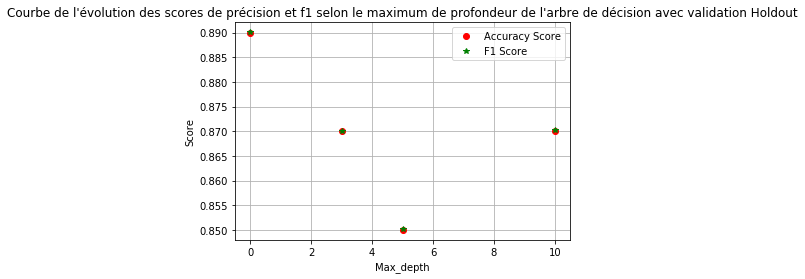

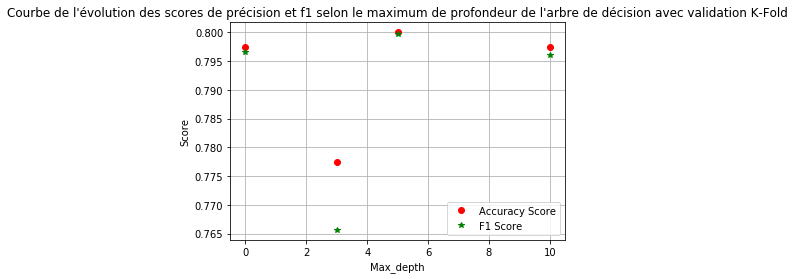

In [144]:
accScores, f1Scores= DecisionTree_Holdout(Filter)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision avec validation Holdout", "Max_depth", "Score")
accScores, f1Scores = DecisionTree_KFold(Filter,10)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon le maximum de profondeur de l'arbre de décision avec validation K-Fold", "Max_depth", "Score")

In [153]:
def Bayes_Holdout(array, array_prob ,array_transform=None):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)
    if array_transform is not None:
        array_train_tr, array_val_tr, array_test_tr = SplitVectorData_Holdout(array_transform, 0.6)

    transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
    transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=array_prob))
    if array_transform is not None:
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train_tr, array_val_tr, array_test_tr, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
    else:
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))

    array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
    array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


    validations = [[array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10],
    [array_val_mdlp, array_prediction_val_mdlp],
    [array_val_minmax, array_prediction_val_minmax]]

    return GenerateScores(validations)

    
    
def Bayes_KFold(array, array_prob, k, array_transform=None):
    
    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    if array_transform is not None:
        array_kfold_train_tr, array_kfold_test_tr = SplitVectorData_KFold(array_transform, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test
        
        if array_transform is not None:
            array_train_tr = concatenateWithoutTestPortion(array_kfold_train_tr, i)
            array_val_tr = array_kfold_train_tr[i]
            array_test_tr = array_kfold_test_tr

        transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
        transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=array_prob))
        if array_transform is not None:
            array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train_tr, array_val_tr, array_test_tr, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
        else:
            array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
        array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
        array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


        validations = [[array_val_5, array_prediction_val_5],
                     [array_val_10, array_prediction_val_10],
                     [array_val_mdlp, array_prediction_val_mdlp],
                     [array_val_minmax, array_prediction_val_minmax]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores 
        
    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)

    return accScores_mean, f1Scores_mean
    


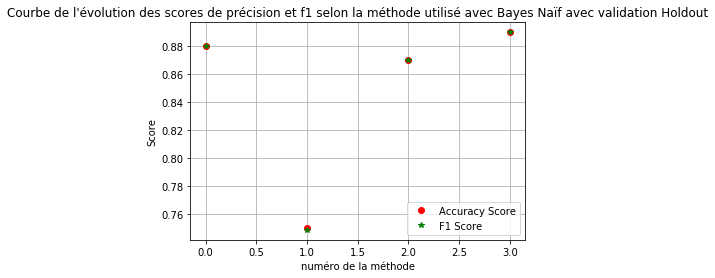

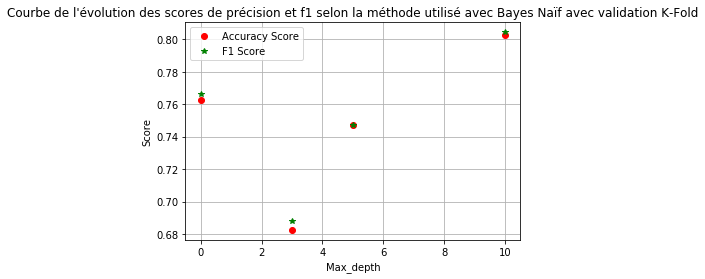

In [154]:
accScores, f1Scores = Bayes_Holdout(Filter, [0.4003,0.5997])
TracePlot([0, 1, 2, 3], accScores, [0, 1, 2, 3], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon la méthode utilisé avec Bayes Naïf avec validation Holdout", "numéro de la méthode", "Score")
accScores, f1Scores = Bayes_KFold(Filter, [0.4003,0.5997], 10)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon la méthode utilisé avec Bayes Naïf avec validation K-Fold", "Max_depth", "Score")

In [155]:
def CreateKNNModel(k, weight):
    return KNeighborsClassifier(n_neighbors=k, weights=weight)

def KNN_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
    array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
    array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
    array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
    array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
    array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

    validations_uniform = [[array_val_3u, array_prediction_val_3u],
                        [array_val_5u, array_prediction_val_5u],
                        [array_val_10u, array_prediction_val_10u]]

    validations_distance = [[array_val_3d, array_prediction_val_3d],
                        [array_val_5d, array_prediction_val_5d],
                        [array_val_10d, array_prediction_val_10d]]

    accScores_uniform, f1Scores_uniform = GenerateScores(validations_uniform)
    accScores_distance, f1Scores_dsitance = GenerateScores(validations_distance)

    return accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_dsitance
    
def KNN_KFold(array, k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores_uniform = np.zeros((k, 3), dtype=float)
    all_f1Scores_uniform = np.zeros((k, 3), dtype=float)
    all_accScores_distance = np.zeros((k, 3), dtype=float)
    all_f1Scores_distance = np.zeros((k, 3), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
        array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
        array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
        array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
        array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
        array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

        validations_uniform = [[array_val_3u, array_prediction_val_3u],
        [array_val_5u, array_prediction_val_5u],
        [array_val_10u, array_prediction_val_10u]]

        validations_distance = [[array_val_3d, array_prediction_val_3d],
        [array_val_5d, array_prediction_val_5d],
        [array_val_10d, array_prediction_val_10d]]

        Array_AccScores_uniform, Array_F1Scores_uniform = GenerateScores(validations_uniform)
        Array_AccScores_distance, Array_F1Scores_distance = GenerateScores(validations_distance)

        all_accScores_uniform[i] = Array_AccScores_uniform
        all_f1Scores_uniform[i] = Array_F1Scores_uniform
        all_accScores_distance[i] = Array_AccScores_distance
        all_f1Scores_distance[i] = Array_F1Scores_distance

    accScores_mean_uniform = scores_mean(all_accScores_uniform)
    f1Scores_mean_uniform = scores_mean(all_f1Scores_uniform)
    accScores_mean_distance = scores_mean(all_accScores_distance)
    f1Scores_mean_distance = scores_mean(all_f1Scores_distance)

    return accScores_mean_uniform, f1Scores_mean_uniform, accScores_mean_distance, f1Scores_mean_distance

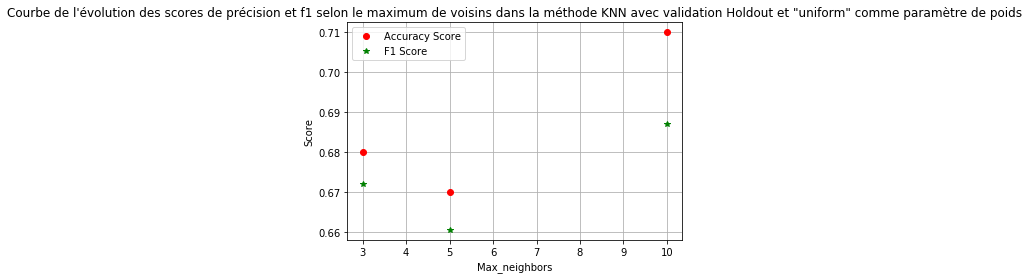

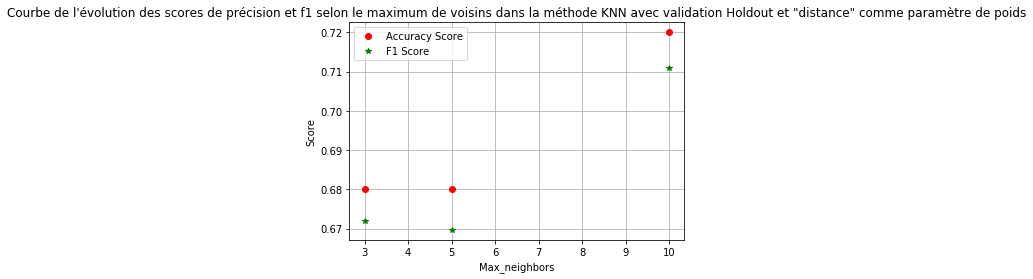

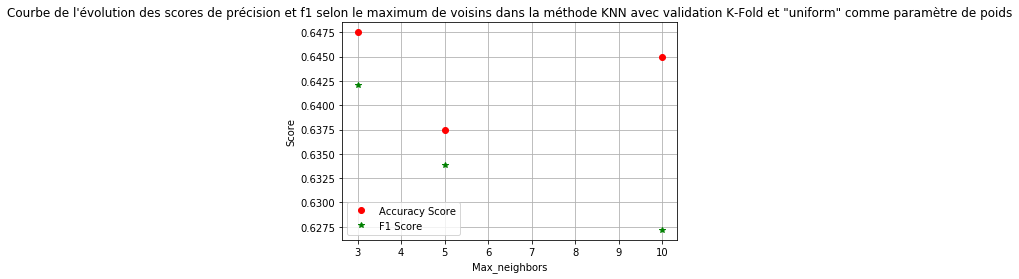

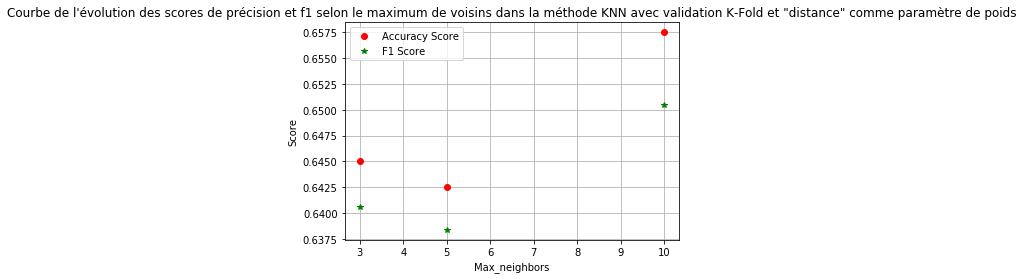

In [156]:
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_Holdout(Filter)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation Holdout et \"uniform\" comme paramètre de poids", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation Holdout et \"distance\" comme paramètre de poids", "Max_neighbors", "Score")
    
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_KFold(Filter, 10)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation K-Fold et \"uniform\" comme paramètre de poids", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation K-Fold et \"distance\" comme paramètre de poids", "Max_neighbors", "Score")
    

### Galaxies

In [157]:
# Get some galaxies
fid = open('galaxy_feature_vectors.csv', 'r') 

NbGalaxy = 500
Galaxies = np.zeros((NbGalaxy, 76), dtype=np.float64)

count = 0
count_smooth = 0
count_spiral = 0

for line in fid:
    element = line.rstrip('\n').split(',')
    
    label = float(element[75])
    
    if label == 0.0 and count_smooth < NbGalaxy/2:
        count_smooth += 1     
    elif label == 1.0 and count_spiral < NbGalaxy/2:
        count_spiral += 1
    else:
        continue

    Galaxies[count] = element
        
    count += 1
    if count >= NbGalaxy:
        break

fid.close() 

# ----- For debug -----
#print(count_smooth)
#print(count_spiral)
#print(count)
#print(Galaxies)
#----------------------

In [158]:
def GetGalaxiesClassProbabilities():
    count_smooth = 0
    count_spiral = 0
    
    fid = open('galaxy_feature_vectors.csv', 'r') 
    for line in fid:
        element = line.rstrip('\n').split(',')

        label = float(element[75])

        if label == 0.0:
            count_smooth += 1     
        elif label == 1.0:
            count_spiral += 1
    return count_smooth/(count_smooth+count_spiral), count_spiral/(count_smooth+count_spiral)

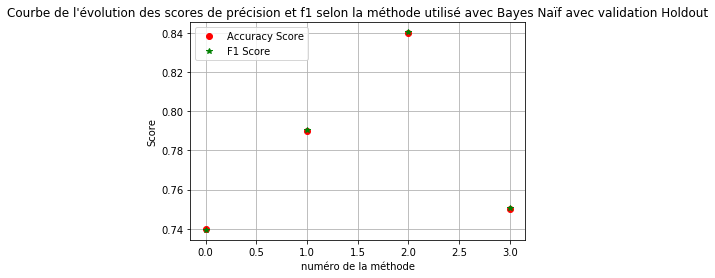

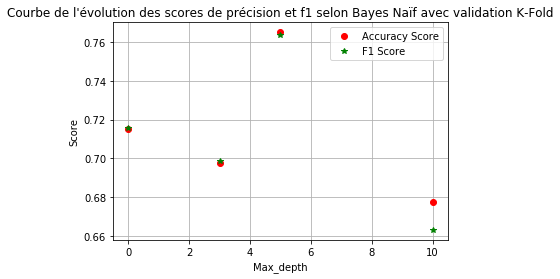

In [159]:
transform = MinMaxScaler()
Galaxies_transform = transform.fit_transform(Galaxies, Galaxies[:,len(Galaxies[0])-1])
smooth_prob, spiral_prob = GetGalaxiesClassProbabilities() 


accScores, f1Scores = Bayes_Holdout(Galaxies, [smooth_prob, spiral_prob],Galaxies_transform)
TracePlot([0, 1, 2, 3], accScores, [0, 1, 2, 3], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon la méthode utilisé avec Bayes Naïf avec validation Holdout", "numéro de la méthode", "Score")
accScores, f1Scores = Bayes_KFold(Galaxies, [smooth_prob, spiral_prob], 10, Galaxies_transform)
TracePlot([0, 3, 5, 10], accScores, [0, 3, 5, 10], f1Scores, "Courbe de l'évolution des scores de précision et f1 selon Bayes Naïf avec validation K-Fold", "Max_depth", "Score")

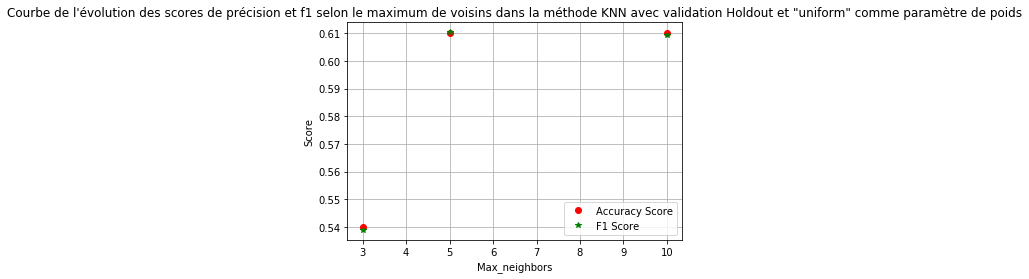

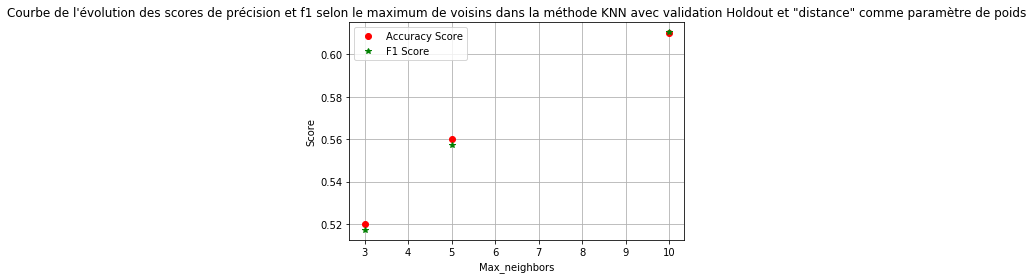

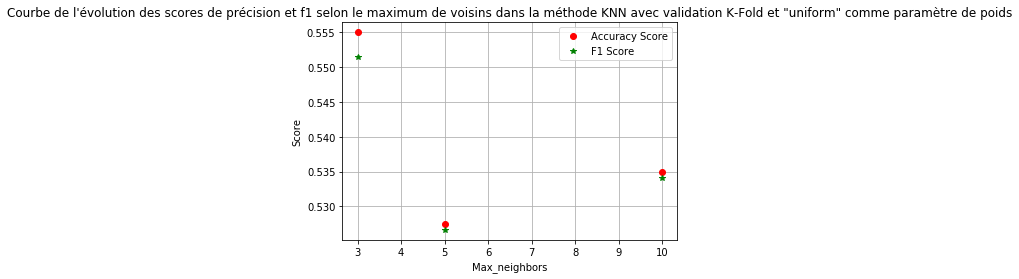

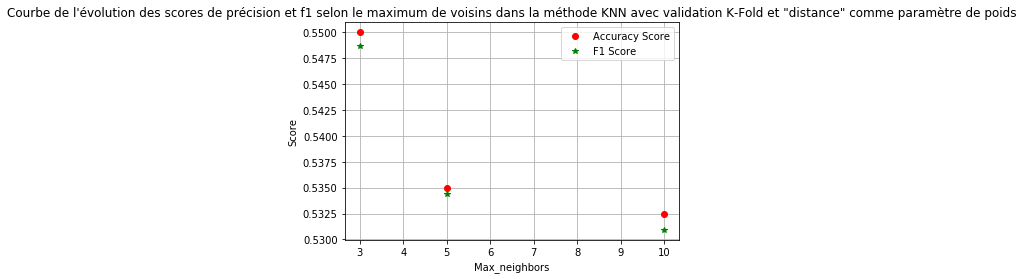

In [160]:
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_Holdout(Galaxies)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation Holdout et \"uniform\" comme paramètre de poids", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation Holdout et \"distance\" comme paramètre de poids", "Max_neighbors", "Score")
    
accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_distance = KNN_KFold(Galaxies, 10)
TracePlot([3, 5, 10], accScores_uniform, [3, 5, 10], f1Scores_uniform, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation K-Fold et \"uniform\" comme paramètre de poids", "Max_neighbors", "Score")
TracePlot([3, 5, 10], accScores_distance, [3, 5, 10], f1Scores_distance, "Courbe de l'évolution des scores de précision et f1 selon le maximum de voisins dans la méthode KNN avec validation K-Fold et \"distance\" comme paramètre de poids", "Max_neighbors", "Score")


# Rapport